# DNA Nanodevice GNN Demo
This demo will show how to use the G3NAT (Graph Neural Network Nucleic Acid Transport) package to create a DNA Nanodevice as a graph and use it to train a graph neural network (GNN) 

In [1]:
# Pytorch moduels
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch

#G3NAT Modules
from dataset import sequence_to_graph
from models import DNATransportGNN, train_model
from data_generator import create_sample_data, getTransmissionDOS
from visualize_dna_graph import visualize_dna_graph

# Other Python modules
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Graph generation
Let's start with a test case: Double stranded DNA with two tails connected to contacts

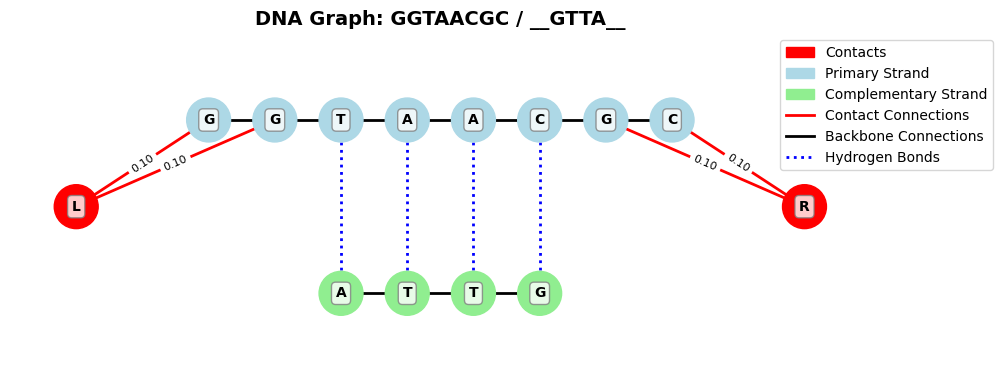

Data(x=[14, 4], edge_index=[2, 36], edge_attr=[36, 5], num_dna_nodes=12)


In [17]:
sequence = "GGTAACGC"
complement = "__GTTA__"
contVal=0.1
lCont = [0,1]
rCont = [len(sequence)-2, len(sequence)-1]
    
# Simple case: left contact at first position, right contact at last position
graph = sequence_to_graph(
    sequence,
    complement,
    left_contact_positions=lCont,  # Connect to first bases (AC)
    right_contact_positions=rCont,  # Connect to last bases (GT)
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)
fig, ax = visualize_dna_graph(graph, sequence, complement, figsize=(10,4))
plt.show()
print(graph)

Now we can use the built in functions to generate density of states (DOS) and coherent transmission with from the tight-binding model

Text(0.5, 0, '$E-E_{HOMO}$ eV')

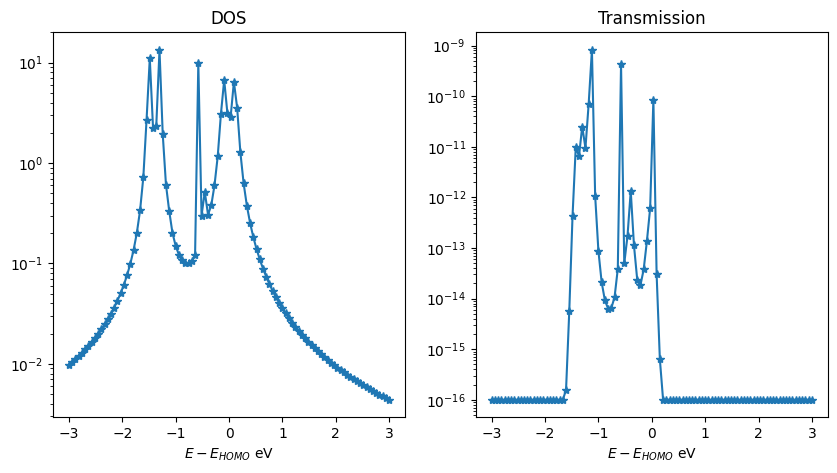

In [21]:
energy_grid=np.linspace(-3,3,100)

# Set up contacts:
gammaL = np.zeros(graph.num_dna_nodes)
gammaL[lCont] = contVal
gammaR = np.zeros(graph.num_dna_nodes)
gammaR[rCont] = contVal

#Get DOS/Transmission
T, dos = getTransmissionDOS(sequence, complement, energy_grid, gammaL, gammaR)
fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, dos, '*-')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.semilogy(energy_grid, T, '*-')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')

# Part 2: Using Pre-trained Model
Let's use our already generated model to see how well it works:

Loading model from: ./trained_models/standard_10000x_4to10BP_1000epoch.pth
Using device: cpu
Detected DNATransportGNN model
DNATransportGNN initialized successfully
Model loaded successfully!
Model parameters: 624,840
Energy grid: 100 points from -3.00 to 3.00 eV
Predicting for sequence: GGTAACGC
                         __ATTG__
Left contact at position [0, 1], coupling: 0.1
Right contact at position [6, 7], coupling: 0.1
Prediction completed!
DOS range: [-16.0591, -8.2379]
Transmission range: [-2.5265, 1.8819]


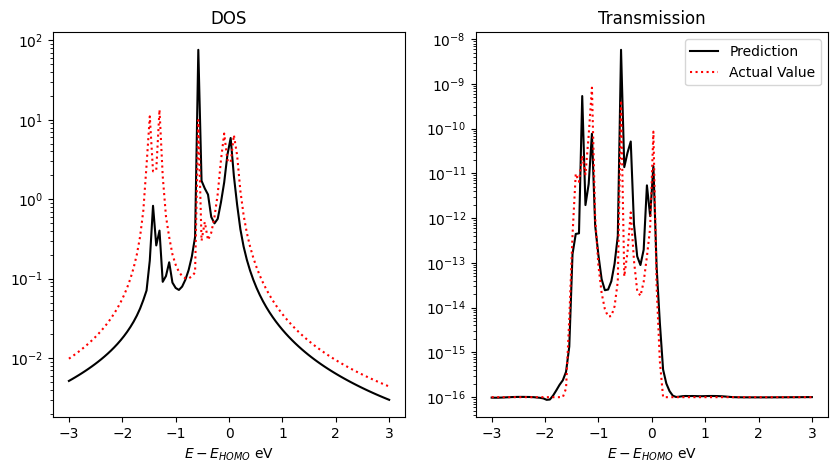

In [22]:
# Or import and use
from models import load_trained_model, predict_sequence

# Load model
model, energy_grid, device = load_trained_model("./trained_models/standard_10000x_4to10BP_1000epoch.pth")

# Predict single sequence
trans_pred, dos_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont, 
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, 10**dos_pred, '-k', energy_grid, dos, ':r')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])
ax2.semilogy(energy_grid, 10**trans_pred, '-k', energy_grid, T, ':r')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])

Loading model from: ./outputs/dna_transport_hamiltonian_model.pth
Using device: cpu
Detected DNATransportHamiltonianGNN model
DNATransportHamiltonianGNN initialized successfully
Model loaded successfully!
Model parameters: 4,538,194
Energy grid: 100 points from -3.00 to 3.00 eV
Predicting for sequence: GGTAACGC
Left contact at position [0, 1], coupling: 0.2
Right contact at position [6, 7], coupling: 0.2
Prediction completed!
DOS range: [0.0000, 0.0000]
Transmission range: [0.0016, 0.0025]
tensor([[[ -0.1113,  -6.3474,   6.5319, -13.1567,  -4.3667,  -1.2589,   3.4223,
           -2.7905,   3.9808,   2.3233,  -2.6487,  -1.2597, -10.8709,  -4.1558,
           -2.2185,  -7.6151,   7.7411,  -3.4432,   0.3474,   1.6150],
         [ -6.3474,   2.9485,   3.2974,   3.3156,   0.4101,   3.0801,   7.4114,
           10.3732,  -3.3895,  -4.0110,   2.5977,   9.2107,  -4.1882,   0.9539,
           -7.0743,  -5.4942,   4.4758,  -7.3411,  -7.0840,  -1.8970],
         [  6.5319,   3.2974,   3.4610,   0

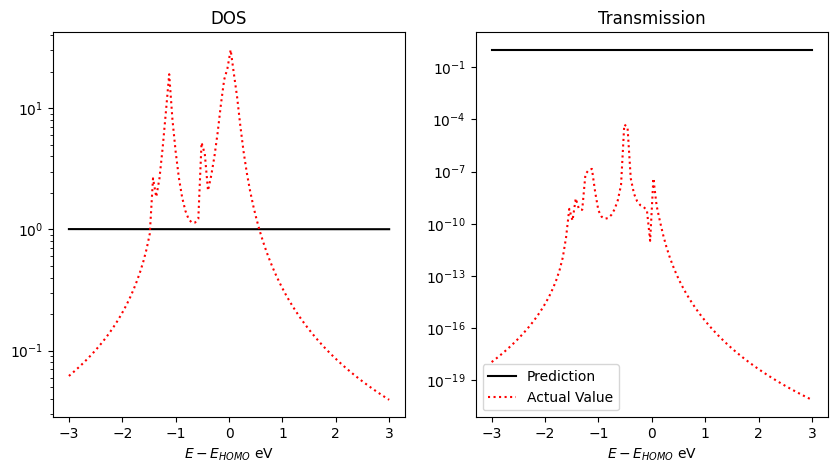

In [6]:
# Or import and use
from models import load_trained_model, predict_sequence

# Load model
model, energy_grid, device = load_trained_model("./outputs/dna_transport_hamiltonian_model.pth")

# Predict single sequence
trans_pred, dos_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=[0,1],  # Connect to first bases (AC)
    right_contact_positions=[0,1],  # Connect to last bases (GT)
    left_contact_coupling=0.2,
    right_contact_coupling=0.2
)
print(model.H)
fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, 10**dos_pred, '-k', energy_grid, dos, ':r')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])
ax2.semilogy(energy_grid, 10**trans_pred, '-k', energy_grid, T, ':r')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])